## Geely Auto Case Study - Linear regression

#### Problem Statement:

A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit there and producing cars locally to give competition to their US and European counterparts.

You are required to model the price of cars with the available independent variables. It will be used by the management to understand how exactly the prices vary with the independent variables. They can accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels. Further, the model will be a good way for management to understand the pricing dynamics of a new market. 



Essentially, the company wants —


- Identification of variables that are significant in predicting the price of a car


- Correlation - How well those variables describe the price of a car <br>

#### Model build/evaluation Approach

Dataset provided `CarPrice_Assignment.csv` <br>
1) we will be using `numpy`, `pandas` to import the data into dataframes, clean this data, check for null values/duplicates and then analyse the data to build the model <br>
2) Perform EDA , Visualize the data using `matplotlib` and `seaborn` <br>
3) Prepare data for analysis ; Dummify Categorical variables wherever necessary <br>
4) Use `train_test_split` ( from sklearn.model_selection) to split data into 70:30 (train:test) ratio <br>
5) Rescale the numerical variables using `MinMaxScaler` (from sklearn.preprocessing) <br>
6) Use Recursive Feature Elimination (`RFE`) to pick 20 best columns using machine learning from `sklearn.feature_selection` <br>
7) Use `LinearRegression` function from SciKit Learn (`sklearn.linear_model`) for its compatibility with RFE  <br>
8) Use `statsmodels.api` to build the stats model with detailed statistics using Ordinary Least Squares(OLS) regression model <br>
9) Use `VIF` (Variable Inflation factor) after every iteration of model building to check for `multicollinearity` <br>
10) Perform `Residual Analysis` of the train data at the end of the model building exercise <br>
11) Make the predictions using the earmarked `test` data <br>
12) `Evaluate` the model and summarize the `equation for the best-fitted line`

#### Import all the libraries

In [1]:
#Import all the libraries you will be using in the notebook
# Supress Warnings
import gc
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime

In [2]:
# Mark the start timestamp of code execution
startTime = datetime.now()

print(startTime)

2019-01-23 14:54:03.509462


#### 1)  Import file and perform duplicate check

In [3]:
cp = pd.read_csv("CarPrice_Assignment.csv")
print("(Rows, Columns) of dataset before dropping duplicates is :", format(cp.shape))
cp = cp.drop_duplicates('car_ID')
print("(Rows, Columns) of dataset after dropping duplicates is :", format(cp.shape))
cp.set_index('car_ID').head(2)

(Rows, Columns) of dataset before dropping duplicates is : (205, 26)
(Rows, Columns) of dataset after dropping duplicates is : (205, 26)


,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,,,,,,,,,,,,,,,,,,,,,
1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0


In [4]:
print("Column information : ")
cp.info()

Column information : 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-nu

#### Inspect null values in the dataframe

In [5]:
round(100*(cp.isnull().sum()/len(cp.index)), 2)

car_ID              0.0
symboling           0.0
CarName             0.0
fueltype            0.0
aspiration          0.0
doornumber          0.0
carbody             0.0
drivewheel          0.0
enginelocation      0.0
wheelbase           0.0
carlength           0.0
carwidth            0.0
carheight           0.0
curbweight          0.0
enginetype          0.0
cylindernumber      0.0
enginesize          0.0
fuelsystem          0.0
boreratio           0.0
stroke              0.0
compressionratio    0.0
horsepower          0.0
peakrpm             0.0
citympg             0.0
highwaympg          0.0
price               0.0
dtype: float64

`No null values to be cleaned` as seen above

1) Expand `column width` and `max column` visibility to print out first couple of records (printing out all the columns of the dataframe) <br>
2) Analyse `categorical variables` and `numerical` variables <br>

In [6]:
# Since column count is more than the default Jupyter settings, let's refit the visible columns
# Expect some new column additions for deriving new dummy columns from existing data hence setting the column limit 100
pd.set_option('max_columns', 100)
pd.set_option('display.max_colwidth', 150)
cp.head(2)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0


#### Per assignment instructions, 
There is a variable named CarName which is comprised of two parts - the first word is the name of 'car company' and the second is the 'car model'. For example, chevrolet impala has 'chevrolet' as the car company name and 'impala' as the car model name. You need to consider only company name as the independent variable for model building. <br>

hence, we drop `CarModel` as it is not needed (non-useful variable) for the present analysis



In [7]:
cp[['CarCompany','CarModel']] = cp['CarName'].str.split(' ' ,1 , expand = True)
#Drop CarName, not useful after this split

cp.drop('CarName', axis=1 , inplace = True)
cp.drop('CarModel', axis=1 , inplace = True)

# Correct the data for Porsche
cp.groupby("CarCompany").mean()['price']

CarCompany
Nissan          5499.000000
alfa-romero    15498.333333
audi           17859.166714
bmw            26118.750000
buick          33647.000000
chevrolet       6007.000000
dodge           7875.444444
honda           8184.692308
isuzu           8916.500000
jaguar         34600.000000
maxda           5645.000000
mazda          11320.600000
mercury        16503.000000
mitsubishi      9239.769231
nissan         10704.882353
peugeot        15489.090909
plymouth        7963.428571
porcshce       32528.000000
porsche        31118.625000
renault         9595.000000
saab           15223.333333
subaru          8541.250000
toyota          9696.645161
toyouta        15750.000000
vokswagen       7775.000000
volkswagen     10175.555556
volvo          18063.181818
vw             10787.500000
Name: price, dtype: float64

`Fix CarCompany, there have been typos and abbreviations that need to be fixed`

In [8]:
cp['CarCompany'] = cp['CarCompany'].replace({'toyouta':'toyota', 
                                       'vokswagen':'volkswagen' , 
                                       'vw':'volkswagen' , 
                                       'porsche':'porcshce' ,
                                        'maxda' : 'mazda' ,
                                         'Nissan' : 'nissan'})
cp.groupby("CarCompany").mean()['price'].sort_values(ascending=False)

CarCompany
jaguar         34600.000000
buick          33647.000000
porcshce       31400.500000
bmw            26118.750000
volvo          18063.181818
audi           17859.166714
mercury        16503.000000
alfa-romero    15498.333333
peugeot        15489.090909
saab           15223.333333
mazda          10652.882353
nissan         10415.666667
volkswagen     10077.500000
toyota          9885.812500
renault         9595.000000
mitsubishi      9239.769231
isuzu           8916.500000
subaru          8541.250000
honda           8184.692308
plymouth        7963.428571
dodge           7875.444444
chevrolet       6007.000000
Name: price, dtype: float64

#### Analyse Outliers that skew the Dependent variable ( price) 

{'whiskers': [<matplotlib.lines.Line2D at 0x1c25ac87b8>,
 'caps': [<matplotlib.lines.Line2D at 0x1c25ac8c50>,
 'boxes': [<matplotlib.patches.PathPatch at 0x1c25ac8550>],
 'medians': [<matplotlib.lines.Line2D at 0x1c25d5b320>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c25d5b668>],
 'means': []}

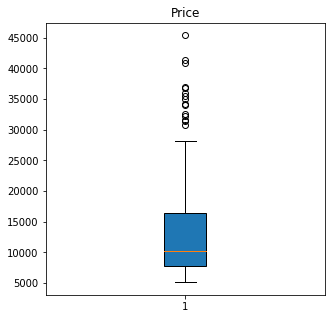

In [9]:
plt.figure(figsize=(5, 5))
plt.title("Price")
plt.boxplot(cp['price'] , patch_artist=True )
# We see that some of the price outliers displayed as circle exists as seen in box plot.
# We hence remove "Outliers" > 25,000 price range as showed in circles

`As we see above, there are lot of outliers in the dataset represented as circles. It is suggested to remove them as they are bound to skew the analysis and hence not useful`

(Rows, Columns) of dataset after dropping duplicates is : (187, 26)


{'whiskers': [<matplotlib.lines.Line2D at 0x1c25da05c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1c25da0a58>,
 'boxes': [<matplotlib.patches.PathPatch at 0x1c25da0358>],
 'medians': [<matplotlib.lines.Line2D at 0x1c25dac128>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c25dac470>],
 'means': []}

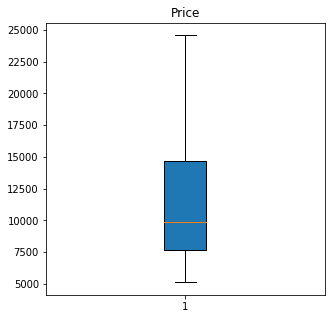

In [10]:
# Remove outliers
cp = cp.loc[ (cp['price'] <= 25000), :]

print("(Rows, Columns) of dataset after dropping duplicates is :", format(cp.shape))

plt.figure(figsize=(5, 5))
plt.title("Price")
plt.boxplot(cp['price'] , patch_artist=True )

As we can see, `18` records dropped out `205` which is about 8.8% of the Data ; `Data looks good now, let's perform Exploratory data analytics leveraging visualization using seaborn and pyplot`

#### 2)  Perform EDA and visualize the  `Categorical` variables

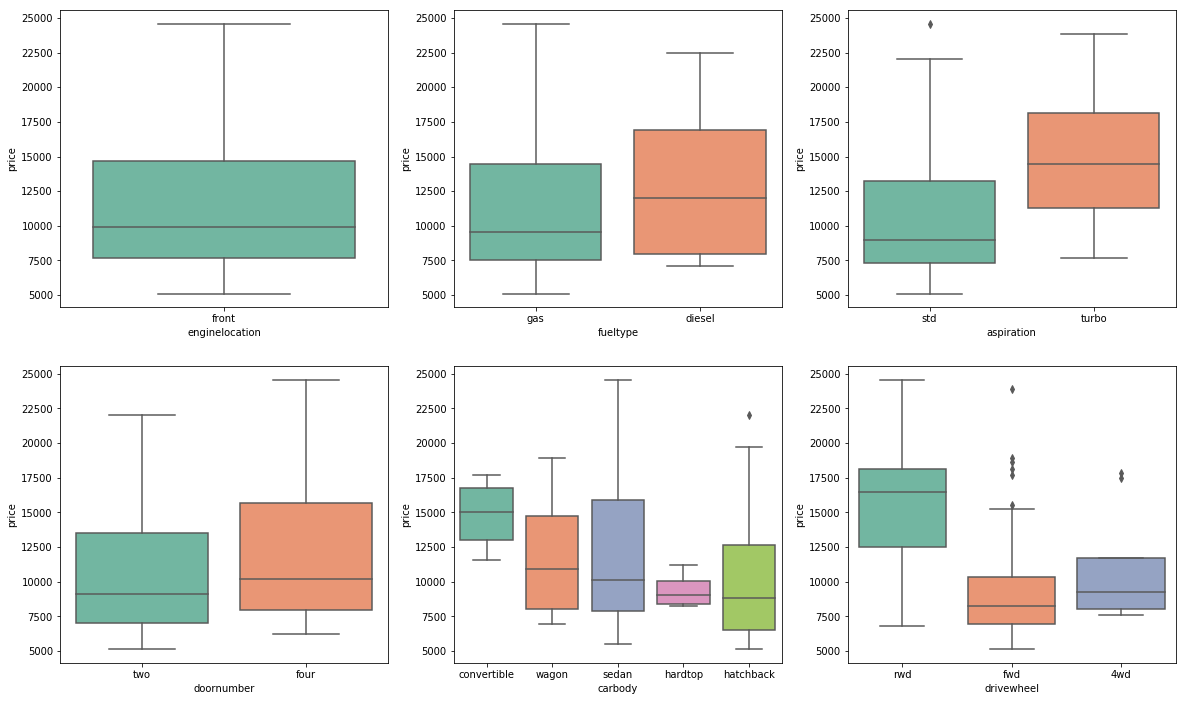

In [11]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'enginelocation', y = 'price', data = cp , palette="Set2")
plt.subplot(2,3,2)
sns.boxplot(x = 'fueltype', y = 'price', data = cp , palette="Set2")
plt.subplot(2,3,3)
sns.boxplot(x = 'aspiration', y = 'price', data = cp, palette="Set2")
plt.subplot(2,3,4)
sns.boxplot(x = 'doornumber', y = 'price', data = cp , palette="Set2")
plt.subplot(2,3,5)
r = cp.groupby("carbody")["price"].median().fillna(0).sort_values()[::-1].index
sns.boxplot(x = 'carbody', y = 'price', data = cp , order = r , palette="Set2")
plt.subplot(2,3,6)
sns.boxplot(x = 'drivewheel', y = 'price', data = cp, palette="Set2")
plt.show()

##### 3)  Dummify Categorical variables `enginelocation` , `fueltype`, `doornumber`, `aspiration` 

In [12]:


mvar = pd.get_dummies(cp['enginelocation'] , prefix = 'enginelocn')
cp.drop('enginelocation', axis=1 , inplace = True)
cp = pd.concat([cp, mvar], axis = 1)

mvar = pd.get_dummies(cp['fueltype'], prefix = 'fueltype')
cp.drop('fueltype', axis=1 , inplace = True)
cp = pd.concat([cp, mvar], axis = 1)

mvar = pd.get_dummies(cp['doornumber'], prefix = 'doornumber')
cp.drop('doornumber', axis=1 , inplace = True)
cp = pd.concat([cp, mvar], axis = 1)

mvar = pd.get_dummies(cp['aspiration'], prefix = 'aspiration')
cp.drop('aspiration', axis=1 , inplace = True)
cp = pd.concat([cp, mvar], axis = 1)

#### Visualize some more categorical variables

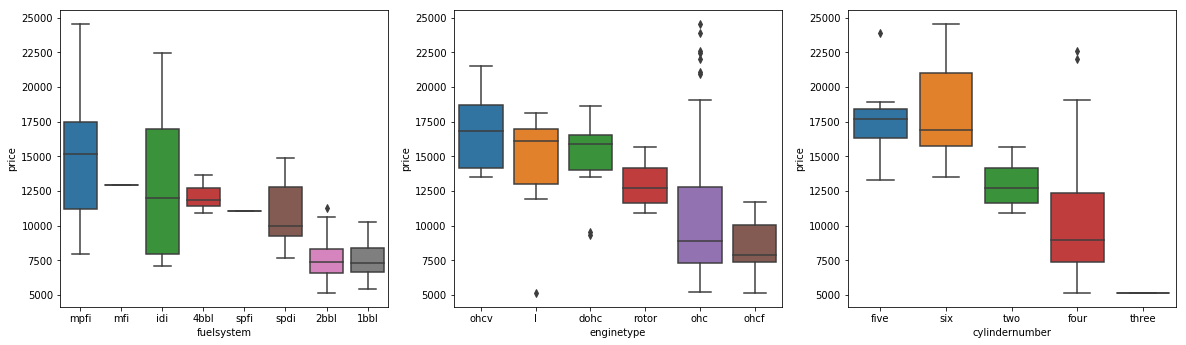

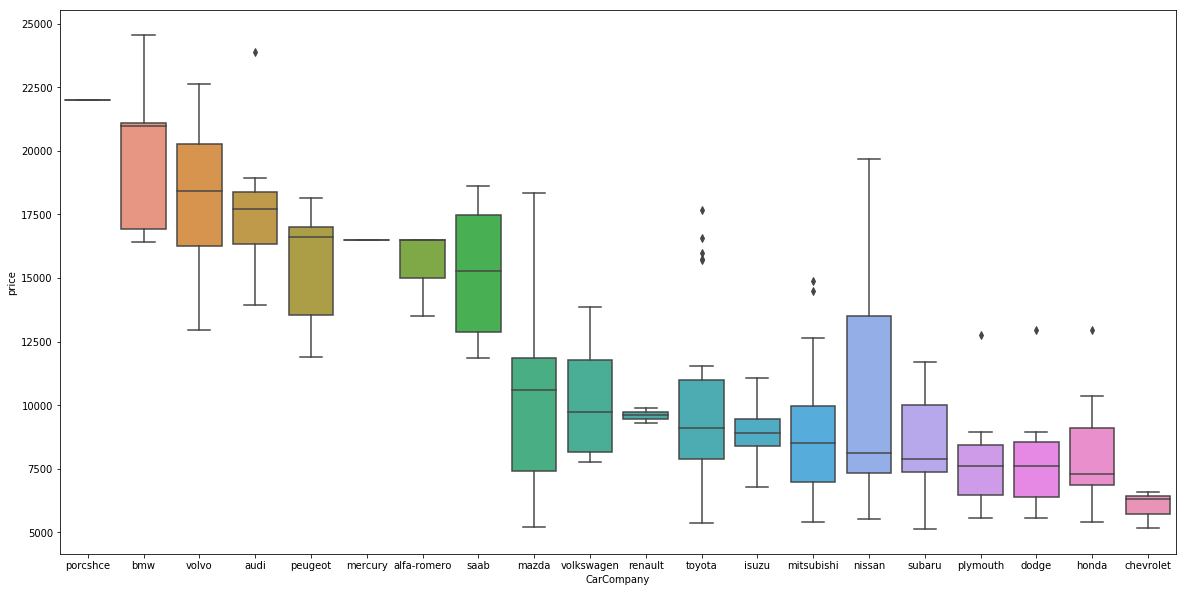

In [13]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
r = cp.groupby("fuelsystem")["price"].median().fillna(0).sort_values()[::-1].index
cp.groupby("fuelsystem").median()['price'].sort_values(ascending=False)
sns.boxplot(x = 'fuelsystem', y = 'price', data = cp , order=r)

plt.subplot(2,3,2)
cp.groupby("enginetype").median()['price'].sort_values(ascending=False)
r = cp.groupby("enginetype")["price"].median().fillna(0).sort_values()[::-1].index
sns.boxplot(x = 'enginetype', y = 'price', data = cp , order =r)

plt.subplot(2,3,3)
cp.groupby("cylindernumber").median()['price'].sort_values(ascending=False)
r = cp.groupby("cylindernumber")["price"].median().fillna(0).sort_values()[::-1].index
sns.boxplot(x = 'cylindernumber', y = 'price', data = cp, order =r)
plt.show()

plt.figure(figsize=(20, 10))
cp.groupby("CarCompany").median()['price'].sort_values(ascending=False)
r = cp.groupby("CarCompany")["price"].median().fillna(0).sort_values()[::-1].index
sns.boxplot(x = 'CarCompany', y = 'price', data = cp, order =r)
plt.show()

In [14]:
print(cp.groupby("carbody").median()['price'].sort_values(ascending=False))
print(cp.groupby("drivewheel").median()['price'].sort_values(ascending=False))
print(cp.groupby("fuelsystem").median()['price'].sort_values(ascending=False))
print(cp.groupby("enginetype").median()['price'].sort_values(ascending=False))
print(cp.groupby("cylindernumber").median()['price'].sort_values(ascending=False))

carbody
convertible    14997.5
wagon          10946.0
sedan          10120.0
hardtop         9044.0
hatchback       8845.0
Name: price, dtype: float64
drivewheel
rwd    16465.0
4wd     9233.0
fwd     8222.0
Name: price, dtype: float64
fuelsystem
mpfi    15145.0
mfi     12964.0
idi     11997.5
4bbl    11845.0
spfi    11048.0
spdi     9959.0
2bbl     7372.0
1bbl     7295.0
Name: price, dtype: float64
enginetype
ohcv     16849.5
l        16105.0
dohc     15874.0
rotor    12745.0
ohc       8921.0
ohcf      7894.0
Name: price, dtype: float64
cylindernumber
five     17710.0
six      16878.5
two      12745.0
four      8948.0
three     5151.0
Name: price, dtype: float64


#### `Dummify` Categorical variables  `carbody`, `drivewheel`, `fuelsystem`,`enginetype`, `cylindernumber`, `CarCompany`

`(variables containing more than 2 values to integer value)`

In [15]:
mvar = pd.get_dummies(cp['carbody'], prefix = 'bodytype')
cp.drop('carbody', axis=1 , inplace = True)
cp = pd.concat([cp, mvar], axis = 1)

mvar = pd.get_dummies(cp['drivewheel'], prefix = 'drivewheel')
cp.drop('drivewheel', axis=1 , inplace = True)
cp = pd.concat([cp, mvar], axis = 1)

mvar = pd.get_dummies(cp['fuelsystem'], prefix = 'fuelsystem')
cp.drop('fuelsystem', axis=1 , inplace = True)
cp = pd.concat([cp, mvar], axis = 1)


mvar = pd.get_dummies(cp['enginetype'], prefix = 'enginetype')
cp.drop('enginetype', axis=1 , inplace = True)
cp = pd.concat([cp, mvar], axis = 1)

mvar = pd.get_dummies(cp['cylindernumber'] ,prefix = 'cylinder')
cp.drop('cylindernumber', axis=1 , inplace = True)
cp = pd.concat([cp, mvar], axis = 1)

mvar = pd.get_dummies(cp['CarCompany'] , prefix = 'company')
cp.drop('CarCompany', axis=1 , inplace = True)
cp = pd.concat([cp, mvar], axis = 1)

##### Creating Derived Variables 

Derive `Wheelbase / Car width` and call it `wb_trackwidth` ; This is one of derivative variable for Aerodynamics consideration (the larger wheelbase means less maneuverability and high stability. if the centre of gravity is more you may loss stability but somewhat gain ground clearance. ;  If you increase car width it may weaken the suspension leading to steering problems.)

In [16]:
cp['wb_trackwidth'] = round(cp.wheelbase/cp.carwidth , 3)

#Drop these columns once wb_trackwidth is derived, as there is chance of multi-collinearity with all three column
# presence

cp.drop('wheelbase', axis=1 , inplace = True)
cp.drop('carwidth', axis=1 , inplace = True)
print(cp.shape)
cp.head(2)

(187, 69)


,car_ID,symboling,carlength,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,enginelocn_front,fueltype_diesel,fueltype_gas,doornumber_four,doornumber_two,aspiration_std,aspiration_turbo,bodytype_convertible,bodytype_hardtop,bodytype_hatchback,bodytype_sedan,bodytype_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,enginetype_dohc,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylinder_five,cylinder_four,cylinder_six,cylinder_three,cylinder_two,company_alfa-romero,company_audi,company_bmw,company_chevrolet,company_dodge,company_honda,company_isuzu,company_mazda,company_mercury,company_mitsubishi,company_nissan,company_peugeot,company_plymouth,company_porcshce,company_renault,company_saab,company_subaru,company_toyota,company_volkswagen,company_volvo,wb_trackwidth
0,1,3,168.8,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.382
1,2,3,168.8,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.382


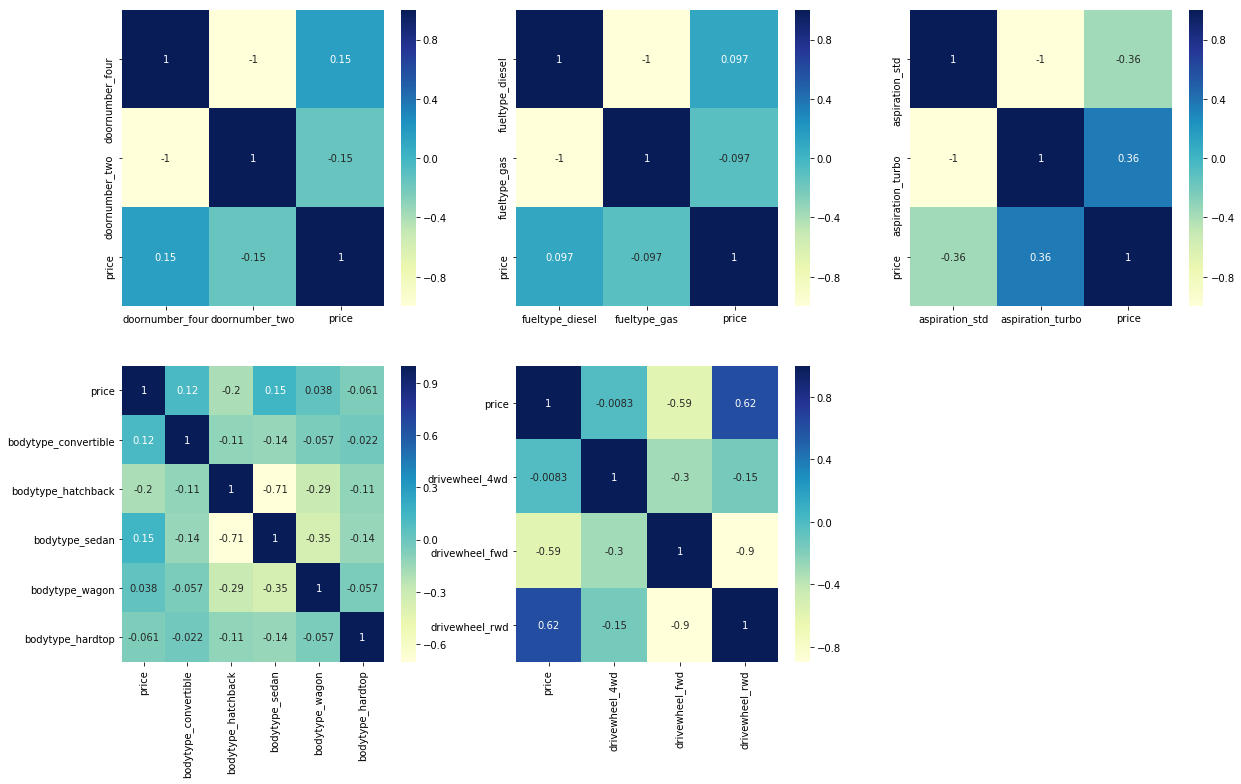

In [17]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
curr = cp[["doornumber_four", "doornumber_two", "price"]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)


plt.subplot(2,3,2)
curr = cp[["fueltype_diesel", "fueltype_gas", "price"]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)

plt.subplot(2,3,3)
curr = cp[["aspiration_std", "aspiration_turbo", "price"]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)

plt.subplot(2,3,4)
curr = cp[["price" , "bodytype_convertible", "bodytype_hatchback", "bodytype_sedan" ,
           "bodytype_wagon" , "bodytype_hardtop" ]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)

plt.subplot(2,3,5)
curr = cp[["price", "drivewheel_4wd" , "drivewheel_fwd" , "drivewheel_rwd" ]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()




#### Let's drop columns that are  `negatively correlated` with `price` as they don't contribute anything to analysis. The reason we are doing this because we are interested in identifying columns which are `significant` predictors ; negative correlation reflect strong deflectors and we at the moment aren't interested in the same 

In [18]:
cp.drop('doornumber_two', axis=1 , inplace = True) # correlation with price -1
cp.drop('fueltype_gas', axis=1 , inplace = True) #  correlation with price -1
cp.drop('aspiration_turbo', axis=1 , inplace = True) #  correlation with price -1
cp.drop('bodytype_hatchback', axis=1 , inplace = True)#  correlation with price -0.2
cp.drop('bodytype_hardtop', axis=1 , inplace = True) #  correlation with price -0.061
cp.drop('drivewheel_fwd', axis=1 , inplace = True) #  correlation with price -0.59
cp.drop('drivewheel_4wd', axis=1 , inplace = True) #  correlation with price -0.0083

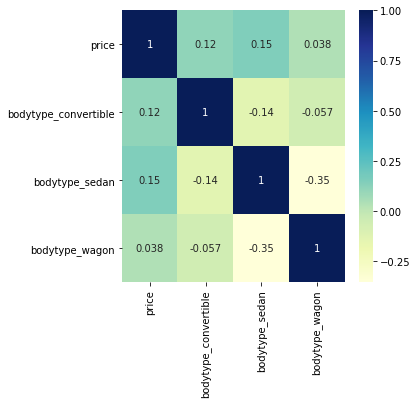

In [19]:
# just confirm printing out that the negative correlation no more exists
plt.figure(figsize=(5, 5))
curr = cp[["price" , "bodytype_convertible",  "bodytype_sedan" ,
           "bodytype_wagon"  ]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)



In [20]:
cp.head(2)

,car_ID,symboling,carlength,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,enginelocn_front,fueltype_diesel,doornumber_four,aspiration_std,bodytype_convertible,bodytype_sedan,bodytype_wagon,drivewheel_rwd,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,enginetype_dohc,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylinder_five,cylinder_four,cylinder_six,cylinder_three,cylinder_two,company_alfa-romero,company_audi,company_bmw,company_chevrolet,company_dodge,company_honda,company_isuzu,company_mazda,company_mercury,company_mitsubishi,company_nissan,company_peugeot,company_plymouth,company_porcshce,company_renault,company_saab,company_subaru,company_toyota,company_volkswagen,company_volvo,wb_trackwidth
0,1,3,168.8,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.382
1,2,3,168.8,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.382


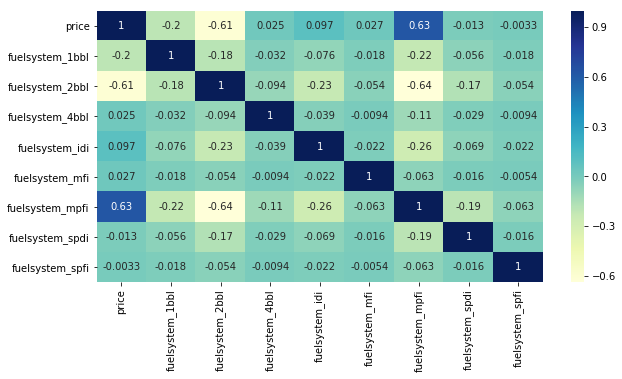

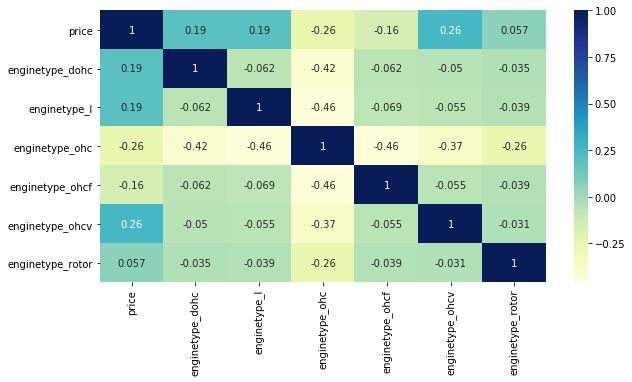

In [21]:
plt.figure(figsize=(10, 5))
curr = cp[["price", "fuelsystem_1bbl", "fuelsystem_2bbl","fuelsystem_4bbl" , "fuelsystem_idi", 
           "fuelsystem_mfi","fuelsystem_mpfi","fuelsystem_spdi", "fuelsystem_spfi"]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()


plt.figure(figsize=(10, 5))
curr = cp[["price", "enginetype_dohc", "enginetype_l", 
            "enginetype_ohc" , "enginetype_ohcf" , "enginetype_ohcv", "enginetype_rotor"]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

In [22]:
# drop negatively correlated columns with price
cp.drop('fuelsystem_1bbl', axis=1 , inplace = True) # correlation with price -0.2
cp.drop('fuelsystem_2bbl', axis=1 , inplace = True) #  correlation with price -0.61
cp.drop('fuelsystem_spdi', axis=1 , inplace = True) #  correlation with price -0.013
cp.drop('fuelsystem_spfi', axis=1 , inplace = True)#  correlation with price -0.0033
cp.drop('enginetype_ohc', axis=1 , inplace = True) #  correlation with price -0.26
cp.drop('enginetype_ohcf', axis=1 , inplace = True) #  correlation with price -0.16

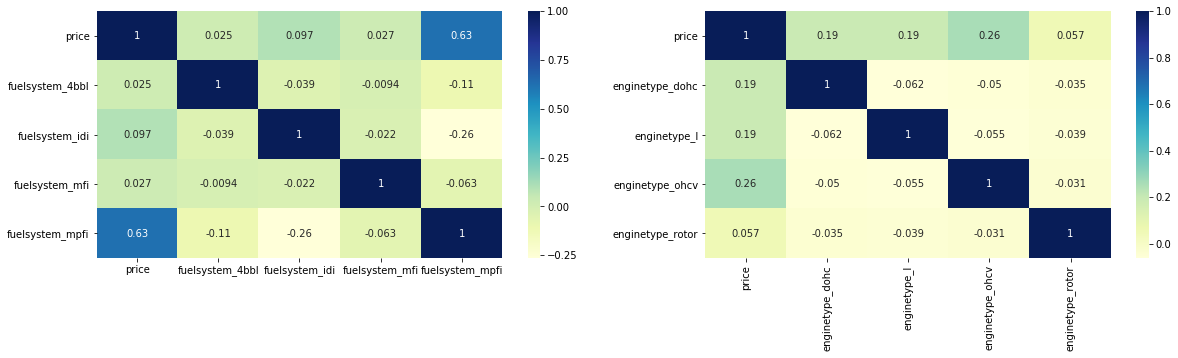

In [23]:
#Verify the correlation again
plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
curr = cp[["price","fuelsystem_4bbl" , "fuelsystem_idi", 
           "fuelsystem_mfi","fuelsystem_mpfi"]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)


plt.subplot(2,2,2)
curr = cp[["price", "enginetype_dohc", "enginetype_l", 
             "enginetype_ohcv", "enginetype_rotor"]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

` columns above are no longer negatively correlated with price`

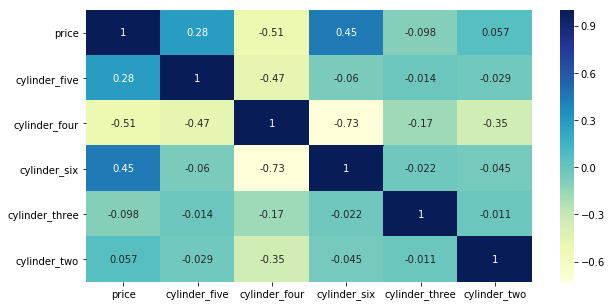

In [24]:
plt.figure(figsize=(10, 5))
curr = cp[["price",  "cylinder_five" , "cylinder_four" ,
           "cylinder_six", "cylinder_three", "cylinder_two" ]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

In [25]:
# drop negatively correlated columns with price
cp.drop('cylinder_four', axis=1 , inplace = True) # correlation with price -0.51
cp.drop('cylinder_three', axis=1 , inplace = True) #  correlation with price -0.098

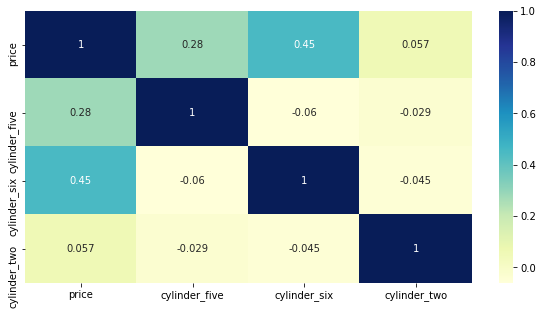

In [26]:
plt.figure(figsize=(10, 5))
curr = cp[["price",  "cylinder_five" , "cylinder_six", "cylinder_two" ]]
cor = curr.corr()
round(cor, 3)
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

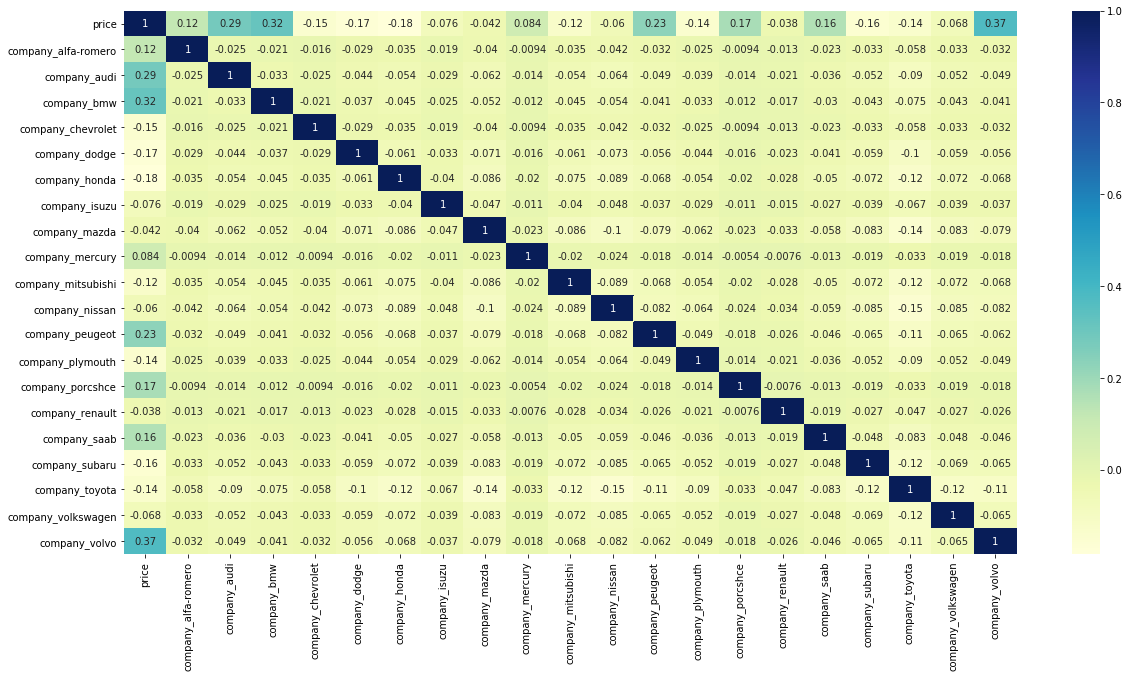

In [27]:
plt.figure(figsize=(20, 10))
curr = cp[["price",  "company_alfa-romero", "company_audi", "company_bmw" ,
 "company_chevrolet" , "company_dodge", "company_honda", 
 "company_isuzu", "company_mazda", "company_mercury" , 
 "company_mitsubishi" , "company_nissan", "company_peugeot" ,
  "company_plymouth","company_porcshce", "company_renault" , 
   "company_saab", "company_subaru", "company_toyota" , 
   "company_volkswagen", "company_volvo" ]]
cor = curr.corr()
round(cor, 2)
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

In [28]:
# drop negatively correlated columns with price
cp.drop('company_chevrolet', axis=1 , inplace = True) # correlation with price -0.51
cp.drop('company_dodge', axis=1 , inplace = True) #  correlation with price -0.098
cp.drop('company_honda', axis=1 , inplace = True) # correlation with price -0.51
cp.drop('company_isuzu', axis=1 , inplace = True) #  correlation with price -0.098
cp.drop('company_mazda', axis=1 , inplace = True) #  correlation with price -0.098
cp.drop('company_mitsubishi', axis=1 , inplace = True) #  correlation with price -0.098
cp.drop('company_nissan', axis=1 , inplace = True) #  correlation with price -0.098
cp.drop('company_plymouth', axis=1 , inplace = True) #  correlation with price -0.098
cp.drop('company_renault', axis=1 , inplace = True) #  correlation with price -0.098
cp.drop('company_subaru', axis=1 , inplace = True) #  correlation with price -0.098
cp.drop('company_toyota', axis=1 , inplace = True) #  correlation with price -0.098
cp.drop('company_volkswagen', axis=1 , inplace = True) #  correlation with price -0.098

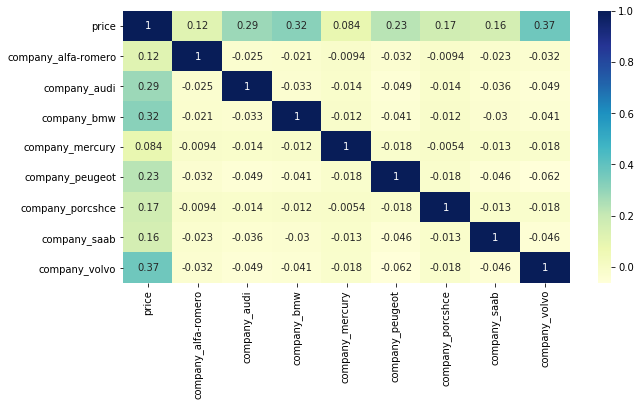

In [29]:
plt.figure(figsize=(10, 5))
curr = cp[["price",  "company_alfa-romero", "company_audi", "company_bmw" ,
 "company_mercury" , 
 "company_peugeot" ,
  "company_porcshce",
   "company_saab", 
   "company_volvo" ]]
cor = curr.corr()
round(cor, 2)
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

`All negative correlations are removed and we are left with strong predictors. let's go and perform test-train split`

#### 4) Test- Train split

In [30]:
cp_train, cp_test = train_test_split(cp, train_size = 0.7, test_size = 0.3, random_state = 100)

#### 5) Rescale the numerical variables using MinMaxScaler (from sklearn.preprocessing) 

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [32]:
num_vars = list(cp.columns)
num_vars = num_vars[1:]
# remove car_ID
cp_train[num_vars] = scaler.fit_transform(cp_train[num_vars])

cp_train.head()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,car_ID,symboling,carlength,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,enginelocn_front,fueltype_diesel,doornumber_four,aspiration_std,bodytype_convertible,bodytype_sedan,bodytype_wagon,drivewheel_rwd,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,enginetype_dohc,enginetype_l,enginetype_ohcv,enginetype_rotor,cylinder_five,cylinder_six,cylinder_two,company_alfa-romero,company_audi,company_bmw,company_mercury,company_peugeot,company_porcshce,company_saab,company_volvo,wb_trackwidth
12,13,0.4,0.593002,0.500000,0.562641,0.846847,0.550000,0.612022,0.1250,0.466216,0.054054,0.151515,0.235294,0.815139,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.667692
19,20,0.6,0.208103,0.290909,0.090858,0.180180,0.350000,0.568306,0.1625,0.121622,0.675676,0.666667,0.676471,0.060523,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.433846
95,96,0.6,0.386740,0.409091,0.177765,0.243243,0.435714,0.666667,0.1500,0.114865,0.567568,0.454545,0.500000,0.137862,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418462
78,79,0.8,0.233886,0.181818,0.164221,0.198198,0.307143,0.633880,0.1500,0.108108,0.729730,0.454545,0.529412,0.079755,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.338462
113,114,0.4,1.000000,0.718182,0.887133,0.450450,0.657143,0.065574,0.0875,0.290541,0.459459,0.090909,0.117647,0.595310,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.000000


In [33]:
# divide it into `x` and `y` for model building
y_train = cp_train.pop('price')
X_train = cp_train

#### 6) Use RFE to pick 20 best columns

In [34]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 20)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [35]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('car_ID', False, 20),
 ('symboling', False, 19),
 ('carlength', True, 1),
 ('carheight', False, 18),
 ('curbweight', True, 1),
 ('enginesize', False, 8),
 ('boreratio', True, 1),
 ('stroke', False, 13),
 ('compressionratio', True, 1),
 ('horsepower', True, 1),
 ('peakrpm', False, 14),
 ('citympg', True, 1),
 ('highwaympg', True, 1),
 ('enginelocn_front', False, 21),
 ('fueltype_diesel', False, 2),
 ('doornumber_four', False, 11),
 ('aspiration_std', False, 4),
 ('bodytype_convertible', True, 1),
 ('bodytype_sedan', False, 12),
 ('bodytype_wagon', False, 7),
 ('drivewheel_rwd', True, 1),
 ('fuelsystem_4bbl', True, 1),
 ('fuelsystem_idi', False, 15),
 ('fuelsystem_mfi', False, 22),
 ('fuelsystem_mpfi', False, 9),
 ('enginetype_dohc', True, 1),
 ('enginetype_l', True, 1),
 ('enginetype_ohcv', False, 16),
 ('enginetype_rotor', True, 1),
 ('cylinder_five', True, 1),
 ('cylinder_six', False, 3),
 ('cylinder_two', False, 5),
 ('company_alfa-romero', False, 10),
 ('company_audi', True, 1),
 

In [36]:
col = X_train.columns[rfe.support_]
col

Index(['carlength', 'curbweight', 'boreratio', 'compressionratio',
       'horsepower', 'citympg', 'highwaympg', 'bodytype_convertible',
       'drivewheel_rwd', 'fuelsystem_4bbl', 'enginetype_dohc', 'enginetype_l',
       'enginetype_rotor', 'cylinder_five', 'company_audi', 'company_bmw',
       'company_mercury', 'company_porcshce', 'company_saab', 'wb_trackwidth'],
      dtype='object')

In [37]:
X_train.columns[~rfe.support_]

Index(['car_ID', 'symboling', 'carheight', 'enginesize', 'stroke', 'peakrpm',
       'enginelocn_front', 'fueltype_diesel', 'doornumber_four',
       'aspiration_std', 'bodytype_sedan', 'bodytype_wagon', 'fuelsystem_idi',
       'fuelsystem_mfi', 'fuelsystem_mpfi', 'enginetype_ohcv', 'cylinder_six',
       'cylinder_two', 'company_alfa-romero', 'company_peugeot',
       'company_volvo'],
      dtype='object')

In [38]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

#### 7) using Ordinary Least Squares(OLS) regression model to fit the training data 

In [39]:
# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)
lr = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model
#Let's see the summary of our linear model
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     64.59
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           4.54e-51
Time:                        14:54:15   Log-Likelihood:                 167.27
No. Observations:                 130   AIC:                            -292.5
Df Residuals:                     109   BIC:                            -232.3
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0298 

In [40]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,131.65
7,highwaympg,33.21
6,citympg,29.84
2,curbweight,13.60
5,horsepower,7.11
1,carlength,6.64
14,cylinder_five,6.10
15,company_audi,6.07
13,enginetype_rotor,4.91
10,fuelsystem_4bbl,4.08


#####  prune `highwaympg` as it has VIF of 33.21

In [41]:
X_train_rfe2 = X_train_rfe.drop('highwaympg', 1,)
# Build a second fitted model
X_train_lm = sm.add_constant(X_train_rfe2)
lr_2 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     66.52
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           2.54e-51
Time:                        14:54:15   Log-Likelihood:                 165.42
No. Observations:                 130   AIC:                            -290.8
Df Residuals:                     110   BIC:                            -233.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0903 

In [42]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,103.33
2,curbweight,12.67
6,citympg,7.89
5,horsepower,7.08
1,carlength,6.57
13,cylinder_five,6.08
14,company_audi,6.07
12,enginetype_rotor,4.91
9,fuelsystem_4bbl,4.04
8,drivewheel_rwd,3.77


Prune `Curbweight`

In [43]:
X_train_rfe3 = X_train_rfe2.drop('curbweight', 1,)
# Build a third fitted model
X_train_lm = sm.add_constant(X_train_rfe3)
lr_3 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     67.46
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           3.52e-51
Time:                        14:54:15   Log-Likelihood:                 162.48
No. Observations:                 130   AIC:                            -287.0
Df Residuals:                     111   BIC:                            -232.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0745 

In [44]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe3
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,102.16
5,citympg,7.10
13,company_audi,5.91
12,cylinder_five,5.91
4,horsepower,5.28
1,carlength,5.26
11,enginetype_rotor,4.64
8,fuelsystem_4bbl,4.03
7,drivewheel_rwd,3.57
18,wb_trackwidth,3.25


Prune `citympg`

In [45]:
X_train_rfe4 = X_train_rfe3.drop('citympg', 1,)
# Build a fourth fitted model
X_train_lm = sm.add_constant(X_train_rfe4)
lr_4 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     71.93
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           4.51e-52
Time:                        14:54:15   Log-Likelihood:                 162.36
No. Observations:                 130   AIC:                            -288.7
Df Residuals:                     112   BIC:                            -237.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1009 

In [46]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe4
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,24.86
12,company_audi,5.90
11,cylinder_five,5.89
1,carlength,4.42
10,enginetype_rotor,4.29
7,fuelsystem_4bbl,4.00
6,drivewheel_rwd,3.53
4,horsepower,3.33
17,wb_trackwidth,3.22
2,boreratio,2.02


Prune `company_audi`

In [47]:
X_train_rfe5 = X_train_rfe4.drop('company_audi', 1,)
# Build a fifth fitted model
X_train_lm = sm.add_constant(X_train_rfe5)
lr_5 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr_5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     74.70
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           2.54e-52
Time:                        14:54:15   Log-Likelihood:                 160.48
No. Observations:                 130   AIC:                            -287.0
Df Residuals:                     113   BIC:                            -238.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1030 

In [48]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe5
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,24.83
1,carlength,4.40
10,enginetype_rotor,4.29
7,fuelsystem_4bbl,4.00
6,drivewheel_rwd,3.49
4,horsepower,3.31
16,wb_trackwidth,3.21
2,boreratio,2.01
9,enginetype_l,1.79
8,enginetype_dohc,1.41


##### Model for the most part looks ok from VIF, however enginetype_rotor has a high p-value and needs to be pruned

In [49]:
X_train_rfe6 = X_train_rfe5.drop('enginetype_rotor', 1,)
# Build a sixth fitted model
X_train_lm = sm.add_constant(X_train_rfe6)
lr_6 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr_6.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     80.32
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           2.90e-53
Time:                        14:54:15   Log-Likelihood:                 160.43
No. Observations:                 130   AIC:                            -288.9
Df Residuals:                     114   BIC:                            -243.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1018 

In [50]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe6
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,24.41
1,carlength,4.37
6,drivewheel_rwd,3.33
4,horsepower,3.30
15,wb_trackwidth,3.19
2,boreratio,2.01
9,enginetype_l,1.79
8,enginetype_dohc,1.40
10,cylinder_five,1.37
3,compressionratio,1.35


In [51]:
X_train_rfe7 = X_train_rfe6.drop('fuelsystem_4bbl', 1,)
# Build a seventh fitted model
X_train_lm = sm.add_constant(X_train_rfe7)
lr_7 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr_7.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     86.66
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           3.33e-54
Time:                        14:54:15   Log-Likelihood:                 160.33
No. Observations:                 130   AIC:                            -290.7
Df Residuals:                     115   BIC:                            -247.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1057 

In [52]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe7
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,22.57
1,carlength,4.37
4,horsepower,3.19
14,wb_trackwidth,3.03
6,drivewheel_rwd,2.68
2,boreratio,2.01
8,enginetype_l,1.77
7,enginetype_dohc,1.39
9,cylinder_five,1.36
3,compressionratio,1.34


In [53]:
X_train_rfe8 = X_train_rfe7.drop('company_mercury', 1,)
# Build a eighth fitted model
X_train_lm = sm.add_constant(X_train_rfe8)
lr_8 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr_8.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     92.27
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           9.65e-55
Time:                        14:54:15   Log-Likelihood:                 159.14
No. Observations:                 130   AIC:                            -290.3
Df Residuals:                     116   BIC:                            -250.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1001 

In [54]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe8
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,22.24
1,carlength,4.22
4,horsepower,3.02
13,wb_trackwidth,3.01
6,drivewheel_rwd,2.67
2,boreratio,1.97
8,enginetype_l,1.77
7,enginetype_dohc,1.38
9,cylinder_five,1.36
3,compressionratio,1.33


In [55]:
X_train_rfe9 = X_train_rfe8.drop('wb_trackwidth', 1,)
# Build a ninth fitted model
X_train_lm = sm.add_constant(X_train_rfe9)
lr_9 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr_9.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     99.01
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           2.44e-55
Time:                        14:54:15   Log-Likelihood:                 158.07
No. Observations:                 130   AIC:                            -290.1
Df Residuals:                     117   BIC:                            -252.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0749 

In [56]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe9
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,14.69
1,carlength,2.86
4,horsepower,2.66
6,drivewheel_rwd,2.63
2,boreratio,1.97
8,enginetype_l,1.59
7,enginetype_dohc,1.37
9,cylinder_five,1.34
3,compressionratio,1.33
12,company_saab,1.29


In [57]:
X_train_rfe10 = X_train_rfe9.drop('enginetype_l', 1,)
# Build a tenth fitted model
X_train_lm = sm.add_constant(X_train_rfe10)
lr_10 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr_10.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     107.3
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           5.12e-56
Time:                        14:54:15   Log-Likelihood:                 157.17
No. Observations:                 130   AIC:                            -290.3
Df Residuals:                     118   BIC:                            -255.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0686 

In [58]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe10
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,14.14
1,carlength,2.56
4,horsepower,2.42
6,drivewheel_rwd,2.29
2,boreratio,1.97
7,enginetype_dohc,1.37
8,cylinder_five,1.34
3,compressionratio,1.33
11,company_saab,1.29
5,bodytype_convertible,1.24


In [59]:
X_train_rfe11 = X_train_rfe10.drop('company_saab', 1,)
# Build a eleventh fitted model
X_train_lm = sm.add_constant(X_train_rfe11)
lr_11 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr_11.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     116.4
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           1.48e-56
Time:                        14:54:15   Log-Likelihood:                 155.87
No. Observations:                 130   AIC:                            -289.7
Df Residuals:                     119   BIC:                            -258.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0724 

enginetype_dohc with p-value of 0.06 after rounding off  and slightly more than border case ; moreover `DOHC` is `Double OverHead Cam `and it is strongly associated to `produce more power` ; we already have horsepower so we will prune this column

In [60]:
X_train_rfe12 = X_train_rfe11.drop('enginetype_dohc', 1,)
# Build a twelveth fitted model
X_train_lm = sm.add_constant(X_train_rfe12)
lr_12 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
print(lr_12.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     126.1
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           7.94e-57
Time:                        14:54:15   Log-Likelihood:                 153.86
No. Observations:                 130   AIC:                            -287.7
Df Residuals:                     120   BIC:                            -259.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0708 

In [61]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe12
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,13.99
1,carlength,2.33
4,horsepower,2.18
6,drivewheel_rwd,2.11
2,boreratio,1.87
3,compressionratio,1.32
7,cylinder_five,1.25
9,company_porcshce,1.14
8,company_bmw,1.12
5,bodytype_convertible,1.09


`All variables are now good. we are ready to perform Residual analysis to check Error terms`

#### Residual analysis

In [62]:
y_train_price = lr_12.predict(X_train_lm)

Text(0.5, 0, 'Errors')

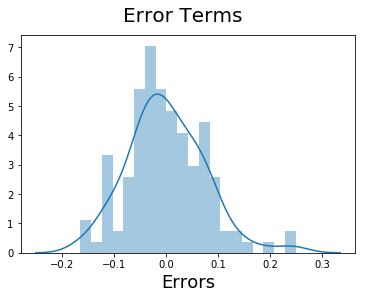

In [63]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

`Although we have slight curve towards the right , the model overall is a decent fit`

#### Making Predictions Using the Final Model

In [64]:
# num_vars = list(X_train_rfe.columns)[1:]

num_vars = list(cp.columns)
num_vars = num_vars[1:]
# remove car_ID
cp_test[num_vars] = scaler.transform(cp_test[num_vars])

cp_test.head()



,car_ID,symboling,carlength,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,enginelocn_front,fueltype_diesel,doornumber_four,aspiration_std,bodytype_convertible,bodytype_sedan,bodytype_wagon,drivewheel_rwd,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,enginetype_dohc,enginetype_l,enginetype_ohcv,enginetype_rotor,cylinder_five,cylinder_six,cylinder_two,company_alfa-romero,company_audi,company_bmw,company_mercury,company_peugeot,company_porcshce,company_saab,company_volvo,wb_trackwidth
11,12,0.4,0.593002,0.500000,0.384876,0.342342,0.685714,0.398907,0.11250,0.331081,0.891892,0.212121,0.264706,0.607137,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.667692
91,92,0.6,0.381215,0.518182,0.115688,0.243243,0.435714,0.666667,0.15000,0.114865,0.567568,0.454545,0.500000,0.078727,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418462
18,19,0.8,-0.064457,0.400000,-0.126975,-0.081081,0.264286,0.524590,0.15625,-0.027027,0.513514,0.939394,0.970588,0.001697,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.372308
88,89,0.2,0.511971,0.254545,0.389391,0.360360,0.450000,0.759563,0.03125,0.432432,0.729730,0.212121,0.294118,0.213966,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.390769
52,53,0.6,0.267035,0.481818,0.108352,0.189189,0.350000,0.590164,0.12500,0.108108,0.459459,0.454545,0.529412,0.086234,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323077


In [65]:
cp_test.columns

Index(['car_ID', 'symboling', 'carlength', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price', 'enginelocn_front',
       'fueltype_diesel', 'doornumber_four', 'aspiration_std',
       'bodytype_convertible', 'bodytype_sedan', 'bodytype_wagon',
       'drivewheel_rwd', 'fuelsystem_4bbl', 'fuelsystem_idi', 'fuelsystem_mfi',
       'fuelsystem_mpfi', 'enginetype_dohc', 'enginetype_l', 'enginetype_ohcv',
       'enginetype_rotor', 'cylinder_five', 'cylinder_six', 'cylinder_two',
       'company_alfa-romero', 'company_audi', 'company_bmw', 'company_mercury',
       'company_peugeot', 'company_porcshce', 'company_saab', 'company_volvo',
       'wb_trackwidth'],
      dtype='object')

In [66]:
y_test = cp_test.pop('price')
X_test = cp_test

In [67]:
# Now let's use our model (final model or model 12) to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
#X_test_new = X_test[list(X_train_rfe12.columns)[1:]]

X_test_new = X_test[list(X_train_rfe12.columns)[1:]]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [68]:
list(X_train_rfe12.columns)[1:]

['carlength',
 'boreratio',
 'compressionratio',
 'horsepower',
 'bodytype_convertible',
 'drivewheel_rwd',
 'cylinder_five',
 'company_bmw',
 'company_porcshce']

In [69]:
X_test_new.columns

Index(['const', 'carlength', 'boreratio', 'compressionratio', 'horsepower',
       'bodytype_convertible', 'drivewheel_rwd', 'cylinder_five',
       'company_bmw', 'company_porcshce'],
      dtype='object')

In [70]:
X_train_rfe.columns

Index(['const', 'carlength', 'curbweight', 'boreratio', 'compressionratio',
       'horsepower', 'citympg', 'highwaympg', 'bodytype_convertible',
       'drivewheel_rwd', 'fuelsystem_4bbl', 'enginetype_dohc', 'enginetype_l',
       'enginetype_rotor', 'cylinder_five', 'company_audi', 'company_bmw',
       'company_mercury', 'company_porcshce', 'company_saab', 'wb_trackwidth'],
      dtype='object')

In [71]:
# Making predictions using the fourth model

y_pred_m12 = lr_12.predict(X_test_new)

Text(0, 0.5, 'y_pred')

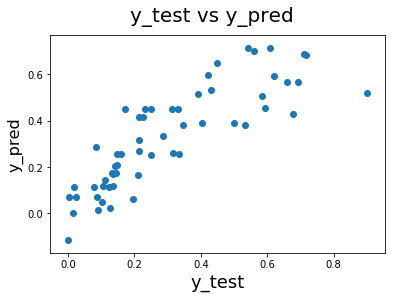

In [72]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred_m12)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16) 

In [73]:
#                       OLS Regression Results                            
# ==============================================================================
# Dep. Variable:                  price   R-squared:                       0.904
# Model:                            OLS   Adj. R-squared:                  0.897
# Method:                 Least Squares   F-statistic:                     126.1
# Date:                Wed, 23 Jan 2019   Prob (F-statistic):           7.94e-57
# Time:                        11:58:53   Log-Likelihood:                 153.86
# No. Observations:                 130   AIC:                            -287.7
# Df Residuals:                     120   BIC:                            -259.0
# Df Model:                           9                                         
# Covariance Type:            nonrobust                                         
# ========================================================================================
#                            coef    std err          t      P>|t|      [0.025      0.975]
# ----------------------------------------------------------------------------------------
# const                   -0.0708      0.025     -2.799      0.006      -0.121      -0.021
# carlength                0.3808      0.052      7.358      0.000       0.278       0.483
# boreratio               -0.1218      0.050     -2.430      0.017      -0.221      -0.023
# compressionratio         0.1764      0.033      5.331      0.000       0.111       0.242
# horsepower               0.5613      0.049     11.424      0.000       0.464       0.659
# bodytype_convertible     0.1187      0.057      2.072      0.040       0.005       0.232
# drivewheel_rwd           0.1249      0.022      5.743      0.000       0.082       0.168
# cylinder_five            0.2408      0.039      6.113      0.000       0.163       0.319
# company_bmw              0.3103      0.041      7.480      0.000       0.228       0.392
# company_porcshce         0.3936      0.083      4.757      0.000       0.230       0.557
# ==============================================================================
# Omnibus:                        8.186   Durbin-Watson:                   2.081
# Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.447
# Skew:                           0.475   Prob(JB):                       0.0146
# Kurtosis:                       3.810   Cond. No.                         17.6
#==============================================================================

#### `As asked in the assignment, let's calculate R2_score using sklearn.metrics`

In [74]:

from sklearn.metrics import r2_score

print ('r2_score is ' ,  r2_score(y_test, y_pred_m12))
print('r2_score (rounded off) is ' , round(r2_score(y_test, y_pred_m12),3))


r2_score is  0.6837169451160516
r2_score (rounded off) is  0.684


`r2_score is 0.684 (rounded off to 3 digits)` 

#### CONCLUSION / MODEL DERIVATIVES

1) p-values are `less than 0.05` <br>
2) Per Statsmodel , `Adjusted R-Squared` and `R-Squared` values are `90% approximately` indicating a good fit. (per sklearn.metrics,`R2_Score is 0.684 which also indicates a good score`<br>

3) We can see that the equation of our best fitted line is: <br>

$ price = 0.3808  \times  carlength - 0.1218  \times  boreratio + 0.1764 \times compressionratio + 0.5613  \times horsepower + 0.1187 \times bodytype\_convertible + 0.1249 \times drivewheel\_rwd + 0.2408 \times cylinder\_five + 0.3103 \times company\_bmw + 0.3936 \times company\_porcshce  $ <br>

4) So the conclusion is the following sentiment plays major role in American car market that Chinese company `Geely Auto` can focus on: <br>
    i) Carlength - Length of Car <br>
    ii) Bore ratio - Ratio between cylinder bore diameter and piston stroke <br>
    iii) Compression ratio - ratio of the volume of the cylinder and the combustion chamber <br>
    iv) horsepower - engine horsepower (power needed to move 550 pounds one foot in one second) <br>
    v) Five cylinder engines are preferred <br>
    vi) Convertible cars are preferred in the body type <br>
    vii) Rear wheel drive cars are preferred (drivewheel) <br>
    viii) bmw and porsche brands are preferred in terms of brand value. some lessons can be taken and some best practices can be taken using these two brands as role models in the auto industry <br>

In [75]:
# Delete all temporary dataframes in the same order and Garbage collect so we just have one final dataframe
# that can be printed out from our analysis or exported to csv for any further analysis if needed

del [[vif,cp,plt,mvar,X,X_test,y_test,scaler,X_train,y_train]]
gc.collect()

0

In [76]:
# End of code, print total time taken for execution
print('\nTime elasped: ', datetime.now() - startTime)
#


Time elasped:  0:00:14.892618


`Code runs in 0:00:14.89 seconds on 16GB ram, 2.4GHz processor MacOS High sierra`